# Financial Time-Series Analysis Using RNN Architectures
## Anthony R. Poggioli

This project was completed as part of the [IBM Course on Deep Learning and Reinforcement Learning](https://www.coursera.org/learn/deep-learning-reinforcement-learning?specialization=ibm-machine-learning), part of the [IBM Machine Learning Professional Certification](https://www.coursera.org/professional-certificates/ibm-machine-learning).

## Project Outline and Goals

This project will focus on developing a machine learning model for time series price data with the business goal of being able to predict near-term fluctuations in price. The main goal of this project is to

* Develop a machine-learning model that balances hindcast accuracy and training efficiency which may be employed for near-term price forecasting.

## Learning Goals

In this project, I am to demonstrate proficiency with three types of recurrent neural network (RNN) used for sequential data analysis and forecasting in general and time series data forecasting in particular. Namely, these architectures are:
* **Vanilla RNNs** - The recurrent units in these simple RNNs produce a single *hidden state* which is then passed as input, along with the next element of the input sequence, to the following unit.
* **Long Short-Term Memory (LSTM) Models** - Generically, a neural network has both *long-term memory* -- the weights -- and *short-term memory* -- the pattern of activations induced by a particular input. Vanilla RNNs seek to provide some temporal persistence to short-term neural network memory by passing hidden state outputs to successive units. The problem is that the short-term in the model rapidly decays such that context can only persist over a few sequential elements. LSTMs solve this issue by incorporating the *cell state* -- a sort of running memory that passes through each LSTM unit and is distinct from the hidden layer output -- and a gating mechanism including three gates: a *forget*, *input*, and *output gate*. Respectively, these gates control what elements of the cell state are forgotten, which elements are updated, and how the updated cell state is combined with the previous hidden state and current input to generate the new hidden state. A good fundamental overview of LSTM networks is available [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).
* **Gated Recurrent Units (GRUs)** - These can be thought of as a simplified version of LSTMs, in which the cell state has been eliminated in favor of just the hidden state and sequential element input (like a vanilla RNN), and there are only two gates: the *reset gate*, which determines what information from the previous hidden state is incorporated into the proposed updates to the hidden state, and the *update gate* which determines which elements of the previous hidden state are updated to create the new hidden state. GRUs are a compromise between the simplicity and training efficiency of vanilla RNNs and the sophistication and computational demand of LSTMs. In many cases, they can perform as well as LSTMs while being much more efficient in their training.

## Data

For this project, I will use time series data of IBM stock prices over five years (2019-01-01 to 2024-01-01), obtained from the Yahoo Finance package. The data is returned as a Pandas DataFrame with the following attributes:
* `Date` **[as index]** = The date in the format `YYYY-MM-DD`.
* `Open` = Opening IBM stock price on the specified date.
* `High` = The highest price obtained on the specified date.
* `Low` = The lowest price obtained on the specified date.
* `Close` = The closing price on the specified date.
* `Adj Close` = Closing price adjusted for any dividend distributions or stock splits on the specified date.
* `Volume` = The total number of shares traded on the specified date.

# Preamble:

Prepare the Google Colaboratory notebook, including loading all needed packages and defining any helper functions:

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project"
file_prefix = %pwd

/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project


In [4]:
!pip install pyyaml h5py

Import the necessary packages:

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

Define our helper functions:

In [6]:
# helper functions

# calcualte the autocorrelation of a numpy vector
def autocorr(time_series_as_np, Lautocorr):
  # calculate normalized temporal autocorrelation
  autocorr = np.zeros(Lautocorr)
  time_series_as_np = time_series_as_np - np.mean(time_series_as_np) # subtract out mean
  autocorr[0] = np.mean(time_series_as_np*time_series_as_np) # variance
  for i in range(1,Lautocorr):
    autocorr[i] = np.mean(time_series_as_np[0:-i]*time_series_as_np[i:])
  autocorr = autocorr/autocorr[0] # normalize to variance of one
  return autocorr

# plot training loss
def loss_plot(history, title = None):
  fig, ax = plt.subplots(figsize = (10, 6))
  ax.plot(history["loss"], color = "blue")
  ax.set_xlabel("epochs")
  ax.set_ylabel("training loss")
  ax.set_title(title)
  plt.show()
  return fig, ax

# plot time-series prediction
def time_series_prediction_plot(test, prediction, title = None):
  fig, ax = plt.subplots(figsize = (10,6))
  plt.plot(np.arange(0, len(test)), test, color = "blue", label = "true testing data")
  plt.plot(np.arange(100, len(test)), prediction, '--', color = "orange", label = "prediction")
  plt.legend()
  plt.xlabel("days since start of test period")
  plt.ylabel("price in USD")
  plt.title(title)
  plt.show()
  return fig, ax

# Data Preparation and Exploration

Load the data:

In [7]:
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2024, 1, 1)
ibm = yf.download("IBM", start, end)
ibm.reset_index(inplace = True)
ibm.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,107.084129,110.879539,106.778206,110.143402,83.947754,4434935
1,2019-01-03,109.493309,109.827919,107.734222,107.944550,82.271866,4546648
2,2019-01-04,109.856598,112.323135,109.407265,112.160614,85.485214,4683779
3,2019-01-07,112.332695,113.604210,111.539200,112.954109,86.089989,3923755
4,2019-01-08,114.397705,115.267685,113.747612,114.560226,87.314133,4982726


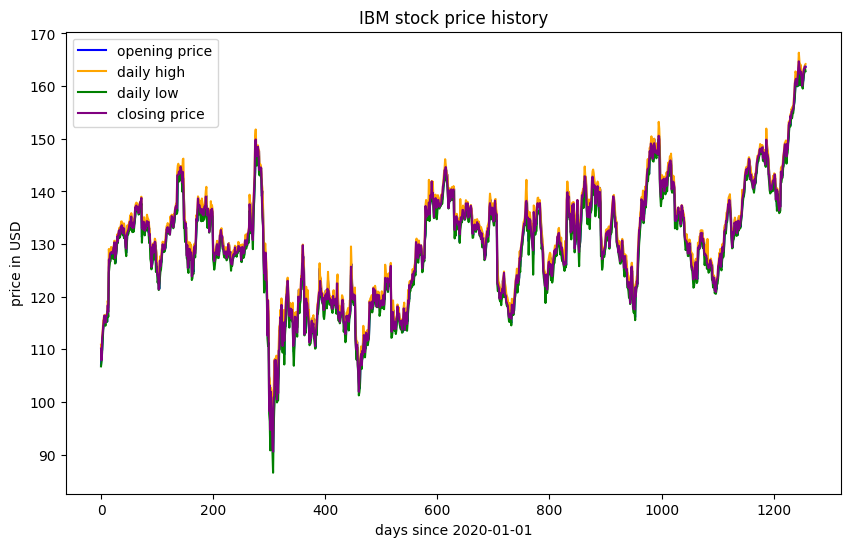

In [8]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(ibm.index, ibm.Open, color = "blue", label = "opening price")
plt.plot(ibm.index, ibm.High, color = "orange", label = "daily high")
plt.plot(ibm.index, ibm.Low, color = "green", label = "daily low")
plt.plot(ibm.index, ibm.Close, color = "purple", label = "closing price")
plt.legend()
plt.xlabel("days since 2020-01-01")
plt.ylabel("price in USD")
plt.title("IBM stock price history")
plt.show()

We see that the variations in the price over the time series far exceeds the difference in the opening, closing, daily high, and daily low prices. Therefore, we can focus on just one of these time series. We will focus on the closing price time series.

In [9]:
time_series = ibm.Close

Let's take a look at the autocorrelation of the closing price, normalized by the variance and starting at the beginning of our time series.

Of course, in reality, the autocorrelation of the stock price will *not be time translation invariant*, but we can get a sense of how much correlation is in our data -- and how important recursion is in our model -- from this rough approximation.

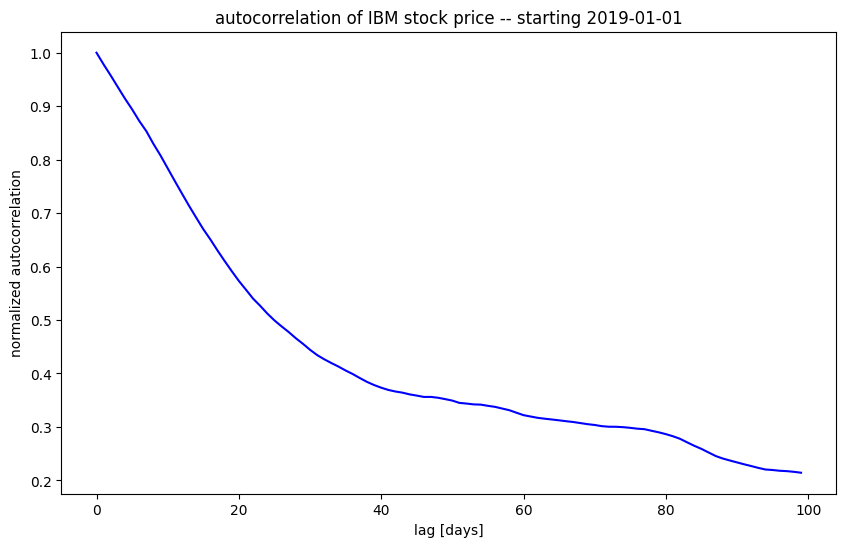

In [10]:
autocorr = autocorr(time_series.to_numpy(), 100)
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(autocorr, color = "blue")
plt.xlabel("lag [days]")
plt.ylabel("normalized autocorrelation")
plt.title("autocorrelation of IBM stock price -- starting 2019-01-01")
plt.show()

This plot is a rough estimate, but it does indeed indicate significant correlation in our data -- on the order of 100 days or more.

Additionally, the deviation of this time-series from exponential decay indicates a deviation of the data from Markovianity -- i.e., the next step in the time series does not just depend on the previous step. It is more complicated than a random walk.

Clearly, incorporating some type of recurrence in our model will be crucial for time-series forecasting.

Next we divide our data into training and testing segments. We must take the end (say the last 25%) of the time series as our testing data (without shuffling) because we are trying to predict the next elements in this ordered sequence.

In [11]:
time_series_train = time_series.iloc[:int(np.ceil(0.75*len(time_series)))].to_numpy().reshape(-1,1)
time_series_test = time_series.iloc[int(np.ceil(0.75*len(time_series))):].to_numpy().reshape(-1,1)

Next, let's scale our data, a crucial step for neural network models. We will use `scikit-learn`'s `MinMaxScaler`. However, unlike in a stationary machine-learning model, we cannot transform the test data based on the parameters of the training data because the minimum and maximum values of the time series are nonstationary parameters. That is, we will have to apply the `fit` method to both the training and testing data separately.

In [12]:
training_scaler = MinMaxScaler().fit(time_series_train)
time_series_train_scaled = training_scaler.transform(time_series_train)
testing_scaler = MinMaxScaler().fit(time_series_test)
time_series_test_scaled = testing_scaler.transform(time_series_test)

We will be performing supervised learning on this data, so we must split our data into input features and prediction targets. We will do this by splitting our data into windows of a fixed length -- 100 days -- treating the price after that window as our prediction target. For example, we will feed the first 100 days of our time series into the model as predictive features and then treat the price on the 101-st day as our predictive target.

In [13]:
X_train = []
y_train = []
for i in range(100, time_series_train_scaled.shape[0]):
  X_train.append(time_series_train_scaled[i-100:i, 0])
  y_train.append(time_series_train_scaled[i, 0])
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = []
y_test = []
for i in range(100, time_series_test_scaled.shape[0]):
  X_test.append(time_series_test_scaled[i-100:i, 0])
  y_test.append(time_series_test_scaled[i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)

# Vanilla RNN Model

We now define a model composed of vanilla RNN layers. After the first layer, we will add a dropout layer with a rate of 0.2 to avoid overfitting. We will then add three more vanilla RNN layers. All RNN layers will be composed of 100 units -- the length of our time series segments -- and the first three layers will pass the entire sequence of hidden states to the subsequent layers. The final layer will pass its final hidden state to our output layer, a dense layer with one unit and a sigmoid activation function (because we have normalized our data to be between zero and one).

In [14]:
def VanillaRNN(input_shape = (100, 1)):
  model = Sequential()
  model.add(SimpleRNN(units = 100,
                      activation = "tanh",
                      return_sequences = True,
                      input_shape = input_shape))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 100,
            activation = "tanh",
            return_sequences = True))
  model.add(SimpleRNN(units = 100,
            activation = "tanh",
            return_sequences = True))
  model.add(SimpleRNN(units = 100,
            activation = "tanh"))
  model.add(Dense(units = 1,
                  activation = "sigmoid"))
  model.compile(optimizer = SGD(learning_rate = 0.01,
                                decay = 1e-6,
                                momentum = 0.9,
                                nesterov = True),
                loss = "mean_squared_error")
  return model

Before fitting our model, let's add a checkpoint callback so we can save our model weights and load them in the future.

In [14]:
file_name = "vanillarnn_1"
checkpoint_path = file_prefix + "/checkpoints/" + file_name + ".weights.h5"
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [15]:
model = VanillaRNN()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100, 100)            │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 100, 100)            │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 100, 100)            │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,601 (275.79 KB)

 Trainable params: 70,601 (275.79 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    batch_size = 2,
                    callbacks = [cp_callback])

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0252
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/vanillarnn_1.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 0.0252
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0055
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/vanillarnn_1.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - loss: 0.0055
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0045
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/vanillarnn_1.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss:

Let's record the time (in seconds) for each epoch for the vanilla RNN. We will compare this data for our different models.

In [41]:
# record epoch training time in seconds from model training output
# this is from the above hidden output (accessible in Colab notebook)
vanillaRNN_time_per_epoch = np.array([85, 62, 44, 81, 81, 42, 83, 81, 81, 43, 80, 41, 43, 80, 81, 43, 43, 79, 43, 81])
vanillaRNN_total_time = np.sum(vanillaRNN_time_per_epoch)
vanillaRNN_avg_time = np.mean(vanillaRNN_time_per_epoch)
vanillaRNN_stdv_time = np.std(vanillaRNN_time_per_epoch)

In [17]:
file_name = "vanillarnn_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "w") as f:
  json.dump(history.history, f, indent = 4)

Let's reload our loss data (in case we've had to restart the notebook) and plot the training loss to make sure it is decreasing as expected.

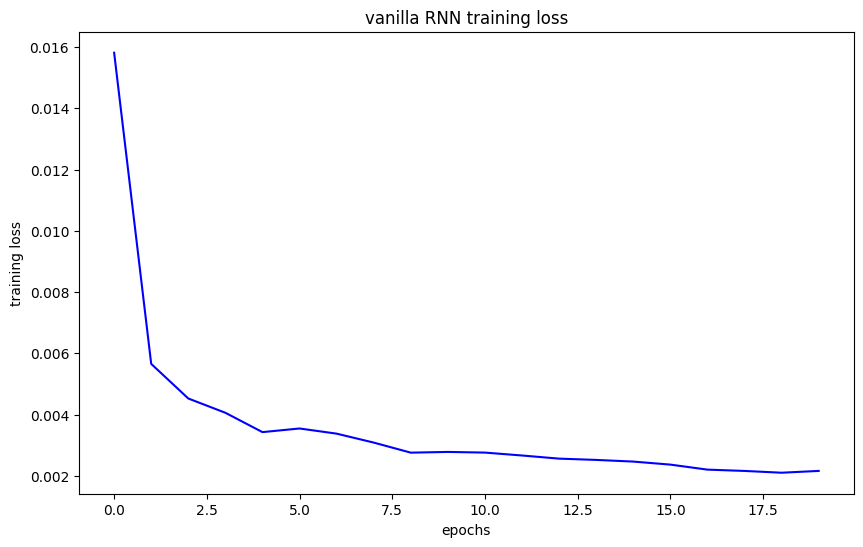

In [18]:
file_name = "vanillarnn_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "r") as f:
  history = json.load(f)
fig, ax = loss_plot(history = history, title = "vanilla RNN training loss")

Now, let's make predictions with our vanilla RNN model and see how they compare to the test data. We will first reinitialize our model and reload the weights in case we have had to restart the Colab notebook.

In [19]:
model = VanillaRNN()
model.load_weights(checkpoint_path)
vRNN_predict_scaled = model.predict(X_test)
# invert the mapping to [0, 1]
vRNN_predict = testing_scaler.inverse_transform(vRNN_predict_scaled)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


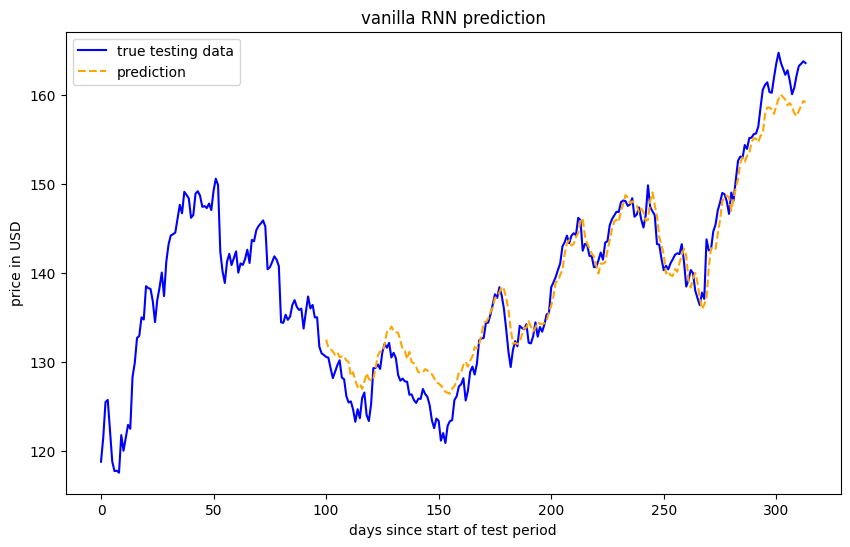

In [20]:
fig, ax = time_series_prediction_plot(test = time_series_test,
                                      prediction = vRNN_predict,
                                      title = "vanilla RNN prediction")

We see already that our vanilla RNN model does reasonably well at following the true data, which is pretty cool! It does struggle significantly in predicting the magnitude of the troughs around 110 days and 150 days after the start of the test period. It also struggles in predicting the magnitude of the peak at the end of the test period.

Now, let's look at how long the model took to train:

In [42]:
print("The total time to train the vanilla RNN model over 20 epochs was " + str(vanillaRNN_total_time) + " seconds = " + str(vanillaRNN_total_time/60) + " minutes")
print("This translates to an average of " + str(vanillaRNN_avg_time) + " +- " + str(vanillaRNN_stdv_time) + " seconds per epoch.")

The total time to train the vanilla RNN model over 20 epochs was 1297 seconds = 21.616666666666667 minutes
This translates to an average of 64.85 +- 18.547978326491542 seconds per epoch.


# LSTM Model

Next, let's build an LSTM model and see if it performs better than our vanilla RNN model. The model is composed of two LSTM layers and two dense layers. The first LSTM passes the entire hidden state sequence to the second LSTM layer. This layer passes the final hidden state to a dense layer composed of 25 units. Finally, this layer feeds into another dense layer with a single unit and a sigmoid activation function -- our prediction layer.

In [16]:
def LSTM_model(input_shape = (100, 1)):
  model = Sequential()
  model.add(LSTM(units = 100,
                 activation = "tanh",
                 return_sequences = True,
                 input_shape = input_shape))
  model.add(LSTM(units = 100,
                 return_sequences = False))
  model.add(Dense(units = 25))
  model.add(Dense(units = 1,
                  activation = "sigmoid"))
  model.compile(optimizer = "adam",
                loss = "mean_squared_error")
  return model

In [22]:
model = LSTM_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
file_name = "LSTM_1"
checkpoint_path = file_prefix + "/checkpoints/" + file_name + ".weights.h5"
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [24]:
history = model.fit(X_train,
                    y_train,
                    epochs = 12,
                    batch_size = 1,
                    callbacks = [cp_callback])

Epoch 1/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0158
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/LSTM_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 129ms/step - loss: 0.0158
Epoch 2/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0034
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/LSTM_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 141s 127ms/step - loss: 0.0034
Epoch 3/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0026
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/LSTM_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 143s 129ms/step - loss: 0.0026
Epoch 4

In [43]:
# As before, let's record the training times
LSTM_time_per_epoch = np.array([112, 141, 143, 143, 109, 140, 108, 142, 107, 144, 139, 145])
LSTM_total_time = np.sum(LSTM_time_per_epoch)
LSTM_avg_time = np.mean(LSTM_time_per_epoch)
LSTM_stdv_time = np.std(LSTM_time_per_epoch)

print("The total time to train the LSTM model over 12 epochs was " + str(LSTM_total_time) + " seconds = " + str(LSTM_total_time/60) + " minutes")
print("This translates to an average of " + str(LSTM_avg_time) + " +- " + str(LSTM_stdv_time) + " seconds per epoch.")

The total time to train the LSTM model over 12 epochs was 1573 seconds = 26.216666666666665 minutes
This translates to an average of 131.08333333333334 +- 15.729263244736615 seconds per epoch.


In [25]:
file_name = "LSTM_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "w") as f:
  json.dump(history.history, f, indent = 4)

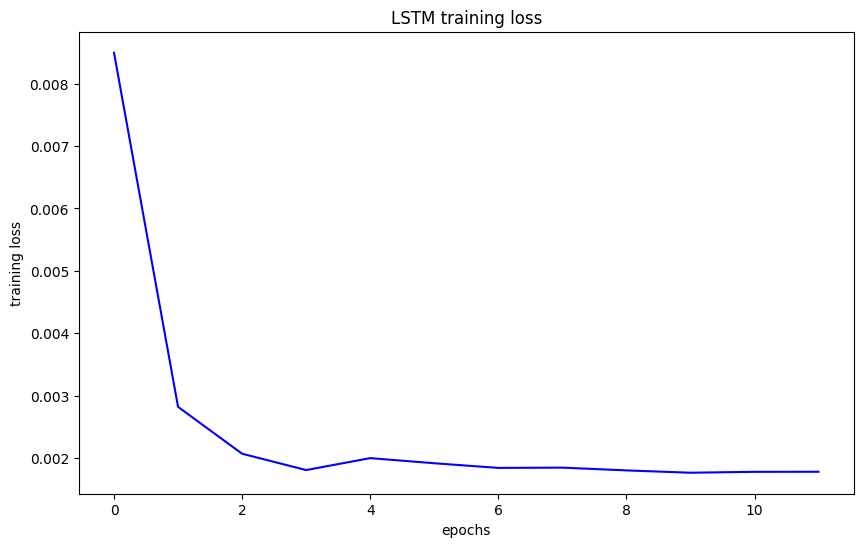

In [26]:
file_name = "LSTM_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
save_path
with open(save_path, "r") as f:
  history = json.load(f)
fig, ax = loss_plot(history = history, title = "LSTM training loss")

In [27]:
model = LSTM_model()
model.load_weights(checkpoint_path)
LSTM_predict_scaled = model.predict(X_test)
# invert the mapping to [0, 1]
LSTM_predict = testing_scaler.inverse_transform(LSTM_predict_scaled)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


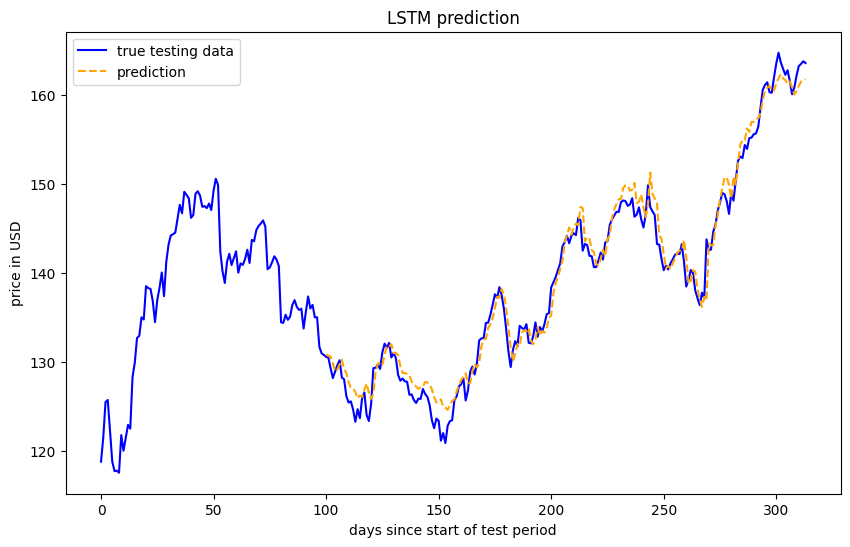

In [28]:
fig, ax = time_series_prediction_plot(test = time_series_test,
                                      prediction = LSTM_predict,
                                      title = "LSTM prediction")

We see that the LSTM model does extremely well, better than the vanilla RNN model over most of the predicted range. This is over only 12 training epochs. Like the vanilla RNN, this model does struggle to predict the magnitude of some of the peaks and troughs in the data, but it appears to be closer on average than the vanilla RNN model.

However, even though the LSTM model is trained over only 12 epochs (compared to 20 for the vanilla RNN), it takes about 20% longer to train than the vanilla RNN, a reflection of this model's greater complexity.

# GRU Model

Finally, let's look at the performance and training time of a GRU model. This model is identical to the vanilla RNN model except we replace the vanilla RNN layers with GRU layers.

In [17]:
def GRU_model(input_shape = (100, 1)):
  model = Sequential()
  model.add(GRU(units = 100,
                activation = "tanh",
                return_sequences = True,
                input_shape = input_shape))
  model.add(Dropout(0.2))
  model.add(GRU(units = 100,
                activation = "tanh",
                return_sequences = True))
  model.add(GRU(units = 100,
                activation = "tanh",
                return_sequences = True))
  model.add(GRU(units = 100,
                activation = "tanh",
                return_sequences = False))
  model.add(Dense(units = 1,
                  activation = "sigmoid"))
  model.compile(optimizer = SGD(learning_rate = 0.01,
                                decay = 1e-7,
                                momentum = 0.7,
                                nesterov = False),
                loss = "mean_squared_error")
  return model

In [30]:
model = GRU_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 100)            │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100, 100)            │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 100, 100)            │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,801 (831.25 KB)

 Trainable params: 212,801 (831.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
file_name = "GRU_1"
checkpoint_path = file_prefix + "/checkpoints/" + file_name + ".weights.h5"
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [32]:
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    batch_size = 1,
                    callbacks = [cp_callback])

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0245
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/GRU_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 235s 271ms/step - loss: 0.0245
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0148
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/GRU_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 261s 270ms/step - loss: 0.0148
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.0072
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/IBM-ML-final-project/checkpoints/GRU_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 230s 272ms/step - loss: 0.0072
Epoch 4/20

In [44]:
# As before, let's record the training times
GRU_time_per_epoch = np.array([235, 261, 230, 263, 262, 263, 230, 374, 272, 231, 262, 264, 237, 258, 261, 263, 230, 259, 231, 265])
GRU_total_time = np.sum(GRU_time_per_epoch)
GRU_avg_time = np.mean(GRU_time_per_epoch)
GRU_stdv_time = np.std(GRU_time_per_epoch)

print("The total time to train the GRU model over 20 epochs was " + str(GRU_total_time) + " seconds = " + str(GRU_total_time/60) + " minutes")
print("This translates to an average of " + str(GRU_avg_time) + " +- " + str(GRU_stdv_time) + " seconds per epoch.")

The total time to train the GRU model over 20 epochs was 5151 seconds = 85.85 minutes
This translates to an average of 257.55 +- 30.52781518549927 seconds per epoch.


In [33]:
file_name = "GRU_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "w") as f:
  json.dump(history.history, f, indent = 4)

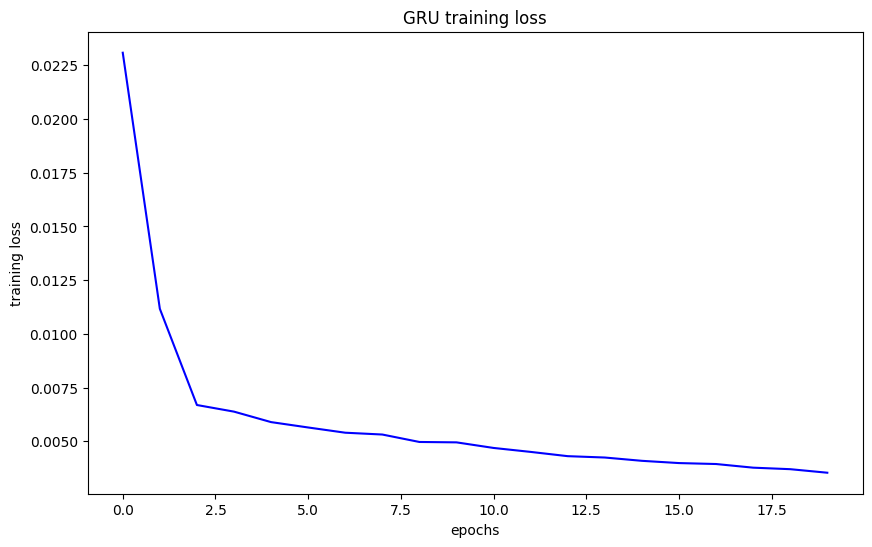

In [34]:
file_name = "GRU_1"
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "r") as f:
  history = json.load(f)
fig, ax = loss_plot(history = history, title = "GRU training loss")

In [39]:
model = GRU_model()
model.load_weights(checkpoint_path)
GRU_predict_scaled = model.predict(X_test)
# invert the mapping to [0, 1]
GRU_predict = testing_scaler.inverse_transform(GRU_predict_scaled)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 676ms/step


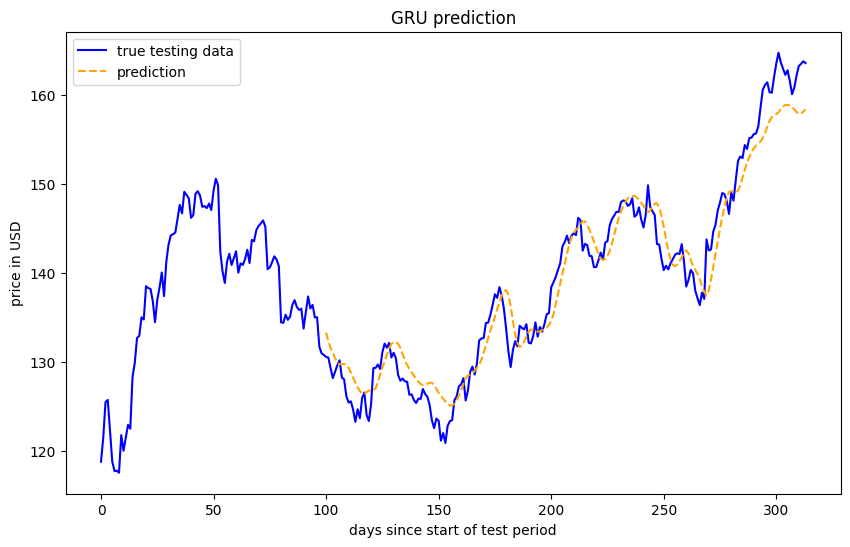

In [40]:
fig, ax = time_series_prediction_plot(test = time_series_test,
                                      prediction = GRU_predict,
                                      title = "GRU prediction")

The GRU model takes significantly longer to train than either of the previous two models, averaging about 258 s/epoch, compared to 65 s/epoch for the vanilla RNN model and 131 s/epoch for the LSTM model. This model also doesn't appear to do any better than the vanilla RNN model.

Of course, the training time is a function of model complexity, and the GRU model was more complex than the LSTM model. However, it still appears that, for this application, the LSTM model offers better predictive power for less computation time.

# Model Comparison

## Model Accuracy

Let's first take a look at how accurate each model is, as measured by the root-mean-squared error over the predicted period:

In [26]:
# load each model, generate predictions, calculate RMSE:
file_names = ["vanillarnn_1", "LSTM_1", "GRU_1"]
models = [VanillaRNN(), LSTM_model(), GRU_model()]
model_names = ["vanilla", "LSTM", "GRU"]
predictions = {}
for file_name, model, model_name in zip(file_names, models, model_names):
  model.load_weights(file_prefix + "/checkpoints/" + file_name + ".weights.h5")
  pred = model.predict(X_test)
  predictions[model_name] = testing_scaler.inverse_transform(pred)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step


In [32]:
rmse_df = {"model": model_names}
rmse_vals = []
for model_name in model_names:
  rmse_vals.append(np.sqrt(mean_squared_error(time_series_test[100:],
                                                   predictions[model_name])))
rmse_df["rmse"] = rmse_vals
rmse_df = pd.DataFrame(rmse_df)

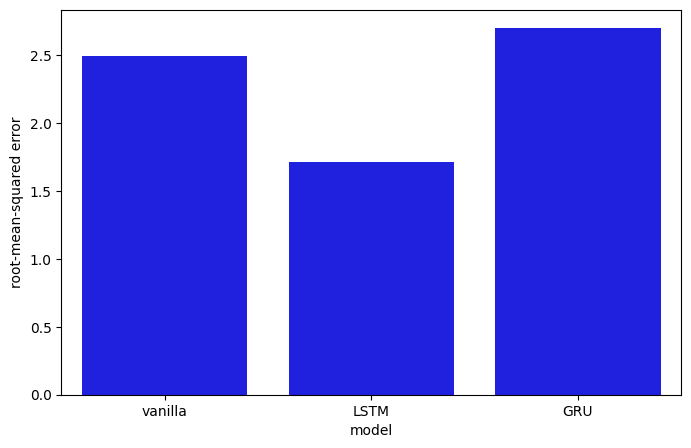

In [33]:
fig = plt.subplots(figsize = (8,5))
sns.barplot(data = rmse_df, x = "model", y = "rmse", color = "blue")
plt.xlabel("model")
plt.ylabel("root-mean-squared error")
plt.show()

Surprisingly, despite its greater complexity than the vanilla RNN, the GRU model performs the worst out of the three.

## Training Time

Next, let's compare the total time and average time per epoch each model took to train:

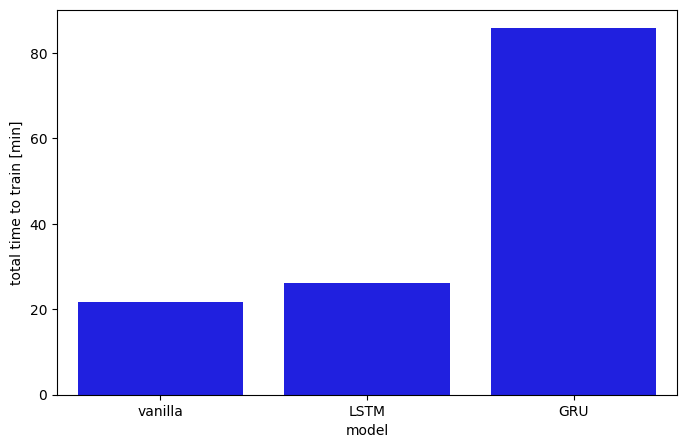

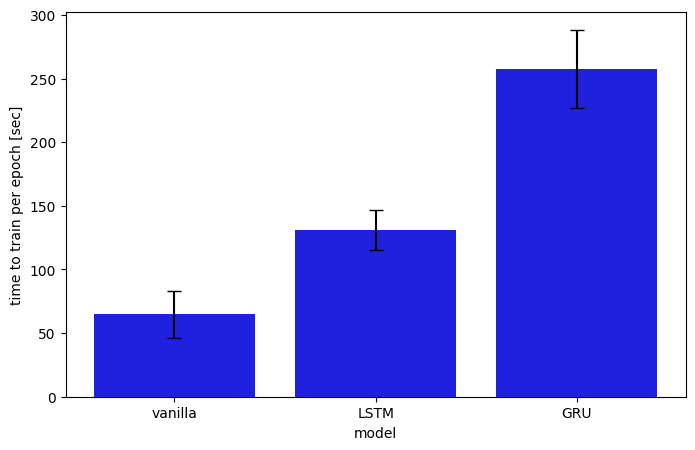

In [63]:
time_df = pd.DataFrame({"model": ["vanilla", "LSTM", "GRU"],
                        "total": [vanillaRNN_total_time/60, LSTM_total_time/60, GRU_total_time/60],
                        "mean": [vanillaRNN_avg_time, LSTM_avg_time, GRU_avg_time],
                        "std": [vanillaRNN_stdv_time, LSTM_stdv_time, GRU_stdv_time]})
fig = plt.subplots(figsize = (8,5))
sns.barplot(data = time_df, x = "model", y = "total", color = "blue")
plt.xlabel("model")
plt.ylabel("total time to train [min]")
plt.show()

fig = plt.subplots(figsize = (8,5))
sns.barplot(data = time_df, x = "model", y = "mean", color = "blue")
plt.errorbar(x = "model", y = "mean", yerr = "std", data = time_df, fmt = "none", color = "black", capsize = 5)
plt.xlabel("model")
plt.ylabel("time to train per epoch [sec]")
plt.show()

The GRU model dominates the other two models both in terms of total training time and average training time per epoch. Given its poor performance, this suggests that GRU models might be a poor choice for this task. However, this will also be a function of the model complexity, hyperparameters, and other factors.

The LSTM takes much longer per epoch than the vanilla RNN. However, it is able to achieve better accuracy than the vanilla RNN after only 12 epochs -- compared to the 20 epochs the vanilla RNN was trained. Overall, it seems like the correct balance of accuracy and training efficiency for this task.

# Conclusions

The three main conclusions of this exercise are:
* The LSTM model is the most accurate of the three in predicting time series data -- even thought it was trained over only 12 epochs. This is expected, given the sophistication of the model.
* Surprisingly, the GRU performs worse than the vanilla RNN even though it is essentially identical to the vanilla RNN (the only difference being that the vanilla RNN layers were replaced with GRU layers), and, like the vanilla RNN, it was trained over 20 epochs.
* The GRU model trains much more slowly than either the vanilla RNN or LSTM model. In fact, it takes about four times as long to train over 20 epochs as the vanilla RNN!
* The total time to train the LSTM model is approximately 20% longer than the vanilla RNN. This seems like a fair tradeoff for the increase in accuracy the LSTM provides.

Overall, it appears that the LSTM model is the ideal model for time series forecasting.

## Furure work
* A first step might be to further fine-tune the LSTM model to see if it can be made even more accurate since it does tend to underpredict the magnitudes of troughs and peaks.
* Beyond this, it will be important for the business goal to investigate how far this model can be extended and what its limitations are. For example, can this model be used to predict several days in advance instead of just one? And, is there anything that can be done to increase its robustness to exogenous market-destabilizing effects, perhaps by incorporating other economic indicators or other outside information? In a business context, investigating these questions would be crucial next steps.